# Climatologia
    Este notebook mostra como calcular medias climatologicas usando a ferramenta python-iris. O python-iris esta configurado no ambiente virtual pyprecis-environment... no entanto tambem pode ser usado no Google Colab. Para isso basta instalar o scitools-iris no ambiente do Colab e atualizar o pacote numpy.
    
    Como pedera ver um processo extramente simples! 
    
    Vamos nos pytonizando!

In [1]:
%matplotlib inline 
import os
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.plot as iplt
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
import dask
dask.config.set(scheduler=dask.get)
import dask.array as da
from iris.analysis import Aggregator
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units


# Libraries to mask AGO
import cartopy.crs as ccrs 
from cartopy.io.shapereader import natural_earth, Reader
from cartopy.mpl.patch import geos_to_path
import iris.plot as iplt
import matplotlib.pyplot as plt
from matplotlib.path import Path
from shapely.geometry import MultiPoint
import cartopy.feature as cf
from iris.analysis.geometry import geometry_area_weights
from iris.util import mask_cube

DATADIR = '/mnt/e'
ERADIR = os.path.join(DATADIR, 'ERA5_daily')

# Approximate region covered by AGO 
lon = (11, 25)
lat = (-19, -4)

# Approximate region covered by AGO 
lon_0 = 10.0
lon_1 = 25.0
lat_0 = -19.0
lat_1 = -4.0

# Mascara de Angola

In [2]:
def get_geometries(country_name):
    """
    Get an iterable of Shapely geometries corrresponding to given country.

    """
    # Using the Natural Earth feature interface provided by cartopy.
    # You could use a different source, all you need is the geometries.
    shape_records = Reader(natural_earth(resolution='110m',
                                         category='cultural',
                                         name='admin_0_countries')).records()
    geoms = []
    for country in shape_records:
        if country.attributes['NAME_LONG'] == country_name:
            geoms.append(country.geometry)
    return geoms

def mask_geom(cube, geom):
    # Create a mask for the data
    mask = np.ones(cube.shape, dtype=bool)

    # Create a set of x,y points from the cube
    x, y = np.meshgrid(cube.coord(axis='X').points, cube.coord(axis='Y').points)
    lat_lon_points = np.vstack([x.flat, y.flat])
    points = MultiPoint(lat_lon_points.T)

    # Find all points within the region of interest (a Shapely geometry)
    indices = [i for i, p in enumerate(points.geoms) if geom.contains(p)]

    mask[np.unravel_index(indices, cube.shape)] = False
    #print(mask)

    # Then apply the mask
    if isinstance(cube.data, np.ma.MaskedArray):
        cube.data.mask &= mask
    else:
        cube.data = np.ma.masked_array(cube.data, mask)
    return cube

def mask_shape(cube, geom):
    cnames = [coord.name() for coord in cube.dim_coords]
    if 'grid_latitude' in cnames and 'grid_longitude' in cnames:
        latname = 'grid_latitude'
        lonname = 'grid_longitude'
    elif 'latitude' in cnames and 'longitude' in cnames:
        latname = 'latitude'
        lonname = 'longitude'
    else:
        raise ValueError('unable to find X and Y axis')

    print(latname, lonname)
    
    country_weights = geometry_area_weights(next(cube.slices(
        [latname, lonname])),
        geom, normalize=True)
    country_mask = np.where(country_weights > 0, False, True)
    
    if 'time' in cnames:
        country_mask = country_mask[np.newaxis,:,:]
        country_mask  = np.broadcast_to(country_mask, cube.data.shape)
    cube = mask_cube(cube, country_mask)
    return cube

LER OS DADOS E CONCATENAR

Este processo deve ser feito apenas uma vez...

In [15]:
time = iris.Constraint(time=lambda cell: PartialDateTime(year=1964) 
                            <= cell.point <= PartialDateTime(year=2022))

infile = os.path.join(ERADIR, 'ERA5_precip_*.nc')
precip = iris.load(infile, time)

print(precip)
print('*' * 120)

unify_time_units(precip)
equalise_attributes(precip)        
cube_precip = precip.concatenate_cube()

print('*' * 120)
outfile = os.path.join(ERADIR, 'era5_pr_daily_1964-2022_AGO.nc')
# iris.save(cube_precip, outfile)
print('Saved: {}'.format(outfile))

0: Total precipitation / (m)           (time: 210384; latitude: 61; longitude: 61)
1: Total precipitation / (m)           (time: 210384; latitude: 61; longitude: 61)
2: Total precipitation / (m)           (time: 96432; latitude: 61; longitude: 61)
************************************************************************************************************************
************************************************************************************************************************
Saved: /mnt/e/ERA5_daily/era5_pr_daily_1964-2022_AGO.nc


In [57]:
time = iris.Constraint(time=lambda cell: PartialDateTime(year=1970) 
                            <= cell.point <= PartialDateTime(year=2022))

infile = os.path.join(ERADIR, 'ERA5_t2m_*.nc')
t2m = iris.load(infile, time)

print(t2m)
print('*' * 120)

unify_time_units(t2m)
equalise_attributes(t2m)        
cube_t2m = t2m.concatenate_cube()

print('*' * 120)
outfile = os.path.join(ERADIR, 'era5_t2m_hourly_1979-2022_AGO.nc')
iris.save(cube_t2m, outfile)
print('Saved: {}'.format(outfile))

0: 2 metre temperature / (K)           (time: 78888; latitude: 61; longitude: 57)
1: 2 metre temperature / (K)           (time: 105192; latitude: 61; longitude: 57)
2: 2 metre temperature / (K)           (time: 105192; latitude: 61; longitude: 57)
3: 2 metre temperature / (K)           (time: 96432; latitude: 61; longitude: 57)
************************************************************************************************************************
************************************************************************************************************************
Saved: /mnt/e/ERA5_daily/era5_t2m_hourly_1979-2022_AGO.nc


 LEAIA OS DADOS
 
 Neste passo, voce le os dados no periodo de interesse.

In [59]:
new_nc = iris.Constraint(time=lambda cell: PartialDateTime(year=1991) 
                            <= cell.point <= PartialDateTime(year=2020))

data_prec = iris.load_cube(os.path.join(ERADIR, 'era5_pr_daily_1964-2022_AGO.nc'), new_nc)
data_temp = iris.load_cube(os.path.join(ERADIR, 'era5_t2m_hourly_1979-2022_AGO.nc'), new_nc)

print(data_prec)
print('=+='*50)
print(data_temp)

Total precipitation / (m)           (time: 262992; latitude: 61; longitude: 61)
     Dimension coordinates:
          time                           x                 -              -
          latitude                       -                 x              -
          longitude                      -                 -              x
     Attributes:
          Conventions: CF-1.7
=+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+==+=
2 metre temperature / (K)           (time: 262992; latitude: 61; longitude: 57)
     Dimension coordinates:
          time                           x                 -              -
          latitude                       -                 x              -
          longitude                      -                 -              x
     Attributes:
          Conventions: CF-1.7


# CLIMATOLOGIA MENSAL

In [61]:
# Adicionando meses
iris.coord_categorisation.add_month(data_prec, 'time', name='month')
iris.coord_categorisation.add_month(data_temp, 'time', name='month')

# Calculando as medias
# a) precipi
prec_tot_mon = data_prec.aggregated_by(['month'], iris.analysis.SUM)/30.0
prec_tot_mon.convert_units('mm')
prec_tot_mon.units = 'mm/month'
prec_tot_mon.rename('precipitation_flux')

# b) temp Media
temp_avg_mon = data_temp.aggregated_by(['month'], iris.analysis.MEAN)
temp_avg_mon.convert_units('Celsius')
temp_avg_mon.units = 'Celsius'
temp_avg_mon.rename('2_metre_temperature')

# Guess bounds e mask
for cube in [prec_tot_mon, temp_avg_mon]:
    for coord in ['latitude', 'longitude']:
        cube.coord(coord).guess_bounds()

country = 'Angola'
geoms = get_geometries(country)
if len(geoms) != 1:
    raise ValueError('Only support one geometry')
    
ago_tot_precip = mask_shape(prec_tot_mon, geoms[0])
ago_avg_temp = mask_shape(temp_avg_mon, geoms[0])

print(ago_tot_precip)
print('=-' * 90)
print(ago_avg_temp)

latitude longitude
latitude longitude
precipitation_flux / (mm/month)     (time: 12; latitude: 61; longitude: 61)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Auxiliary coordinates:
          month                          x             -              -
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
2_metre_temperature / (Celsius)     (time: 12; latitude: 61; longitude: 57)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Auxiliary coordinates:
          mon

In [114]:
# Calculando as medias
# a) Tas max
temp_max_mon = data_temp.aggregated_by(['month'], iris.analysis.MAX)
temp_max_mon.convert_units('Celsius')
temp_max_mon.units = 'Celsius'
temp_max_mon.rename('2_metre_tasmax')

# b) Tas min
temp_min_mon = data_temp.aggregated_by(['month'], iris.analysis.MIN)
temp_min_mon.convert_units('Celsius')
temp_min_mon.units = 'Celsius'
temp_min_mon.rename('2_metre_tasmin')

# Guess bounds e mask
for cube in [temp_min_mon, temp_max_mon]:
    for coord in ['latitude', 'longitude']:
        cube.coord(coord).guess_bounds()

country = 'Angola'
geoms = get_geometries(country)
if len(geoms) != 1:
    raise ValueError('Only support one geometry')
    
ago_min_temp = mask_shape(temp_min_mon, geoms[0])
ago_max_temp = mask_shape(temp_max_mon, geoms[0])

print(ago_min_temp)
print('=-' * 90)
print(ago_max_temp)

latitude longitude
latitude longitude
2_metre_tasmin / (Celsius)          (time: 12; latitude: 61; longitude: 57)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Auxiliary coordinates:
          month                          x             -              -
     Attributes:
          Conventions: CF-1.7
     Cell methods:
          minimum: month
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
2_metre_tasmax / (Celsius)          (time: 12; latitude: 61; longitude: 57)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude   

PLOTS

In [22]:
import calendar

        a) Precipitation

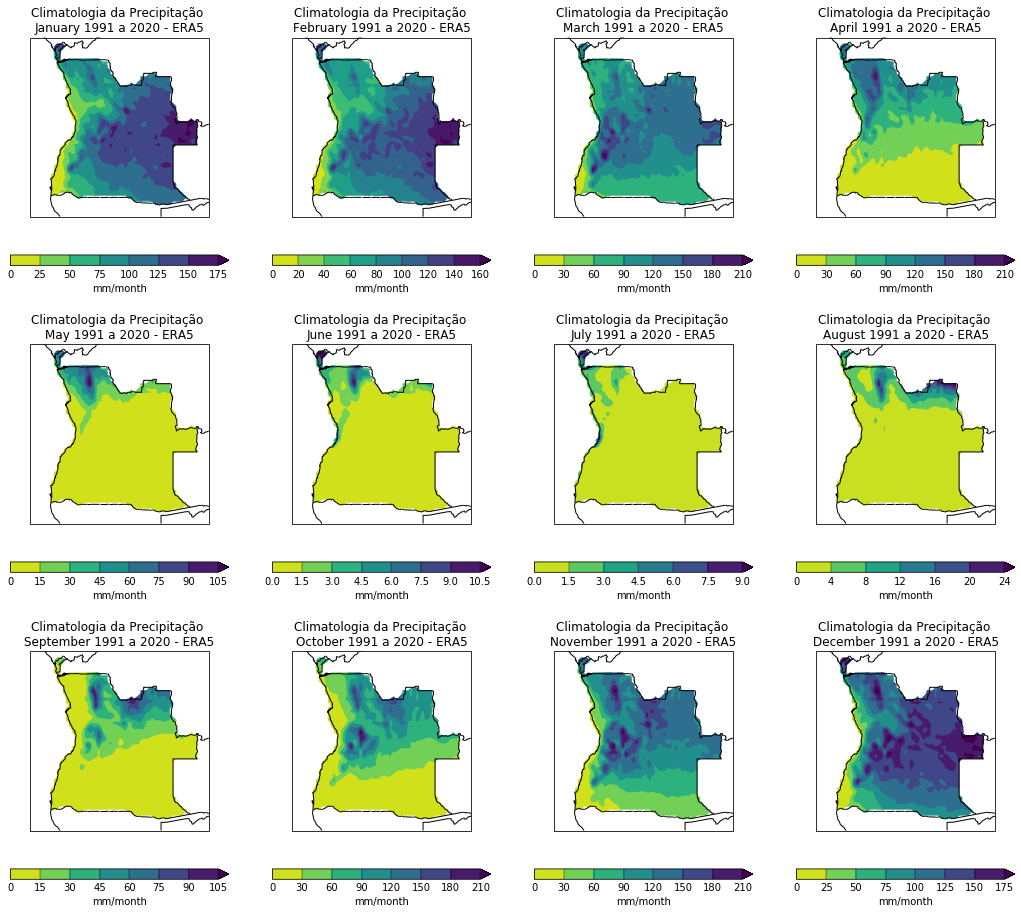

In [110]:
fig = plt.figure(figsize=(18,16))

nrows = 3
ncols = 4
for i in range(1,13):
    plt.subplot(nrows, ncols, i)
    maps = qplt.contourf(ago_tot_mon[i-1], cmap='viridis_r',
                       extend='max')
    plt.title('Climatologia da Precipitação \n'+calendar.month_name[i]+' 1991 a 2020 - ERA5')
    ax = plt.gca()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

        b) Temperature

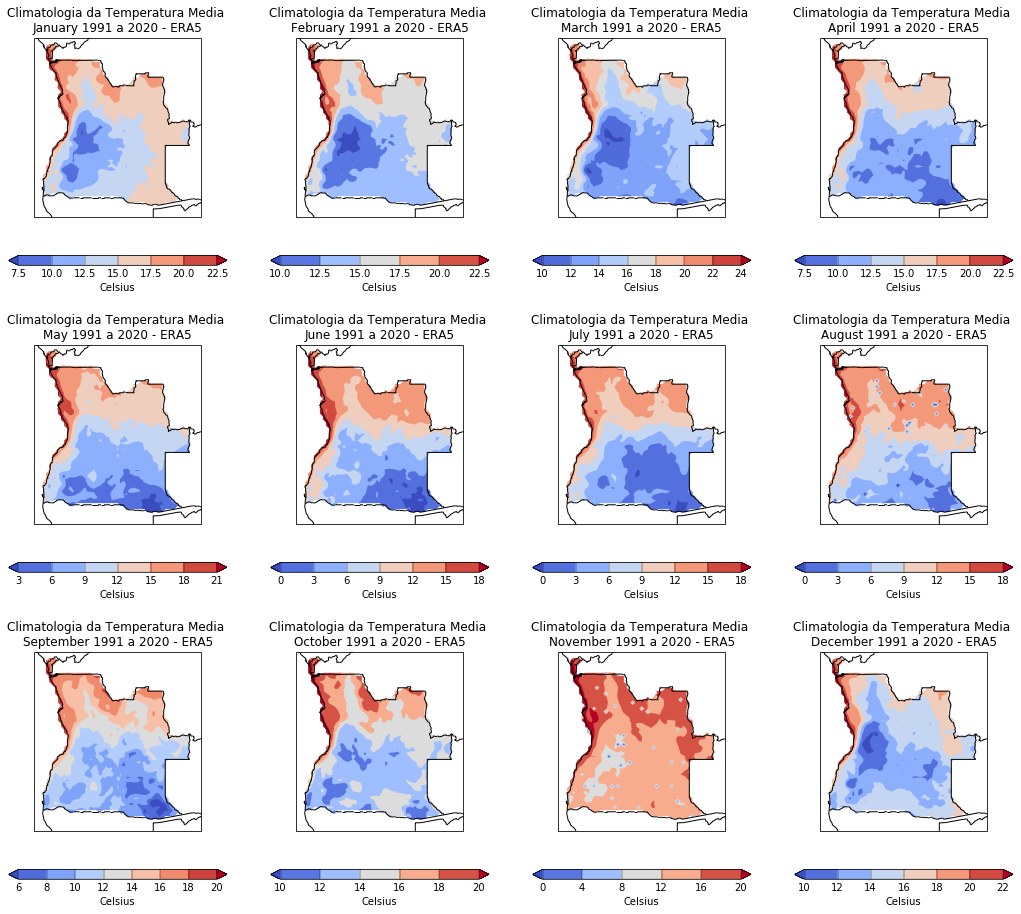

In [115]:
# tasmin
fig = plt.figure(figsize=(18,16))

nrows = 3
ncols = 4
for i in range(1,13):
    plt.subplot(nrows, ncols, i)
    maps = qplt.contourf(ago_min_temp[i-1],
                         cmap='coolwarm',
                         extend='both',
                        )
    plt.title('Climatologia da Temperatura Minima \n'+calendar.month_name[i]+' 1991 a 2020 - ERA5')
    ax = plt.gca()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

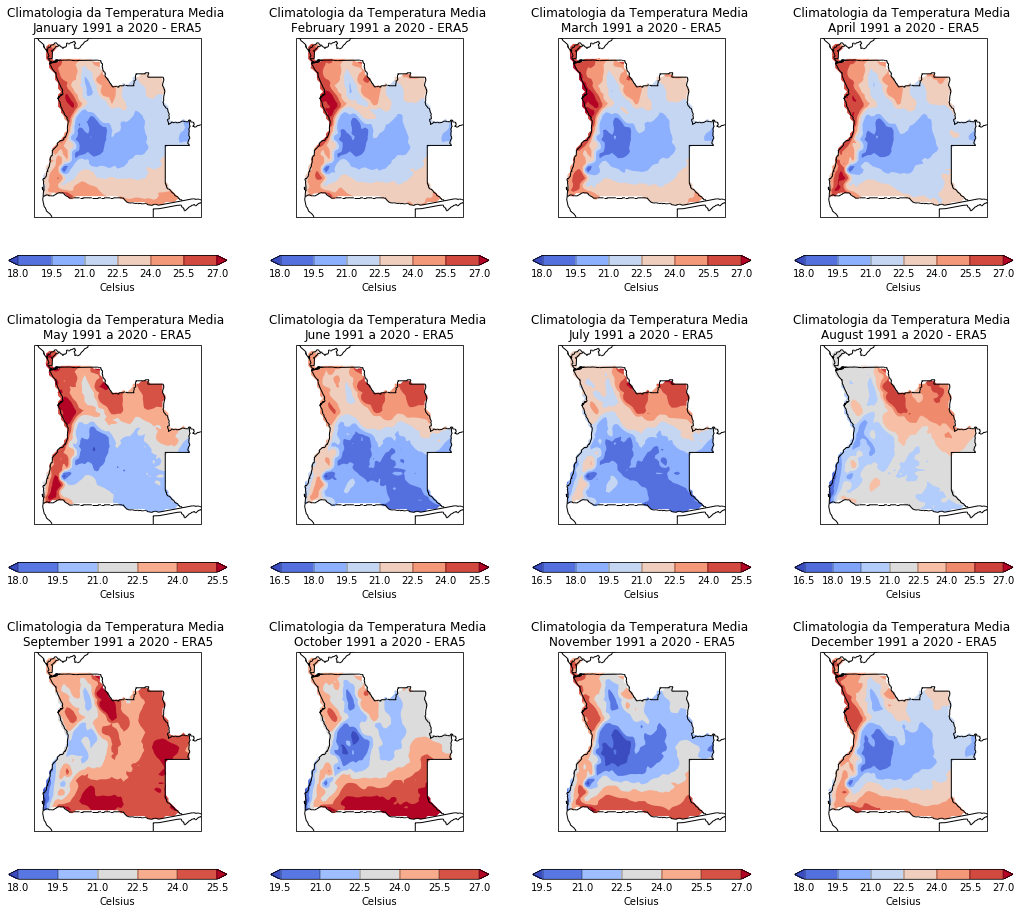

In [64]:
# tas
fig = plt.figure(figsize=(18,16))

nrows = 3
ncols = 4
for i in range(1,13):
    plt.subplot(nrows, ncols, i)
    maps = qplt.contourf(ago_avg_temp[i-1],
                         cmap='coolwarm',
                         extend='both',
                        )
    plt.title('Climatologia da Temperatura Media \n'+calendar.month_name[i]+' 1991 a 2020 - ERA5')
    ax = plt.gca()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

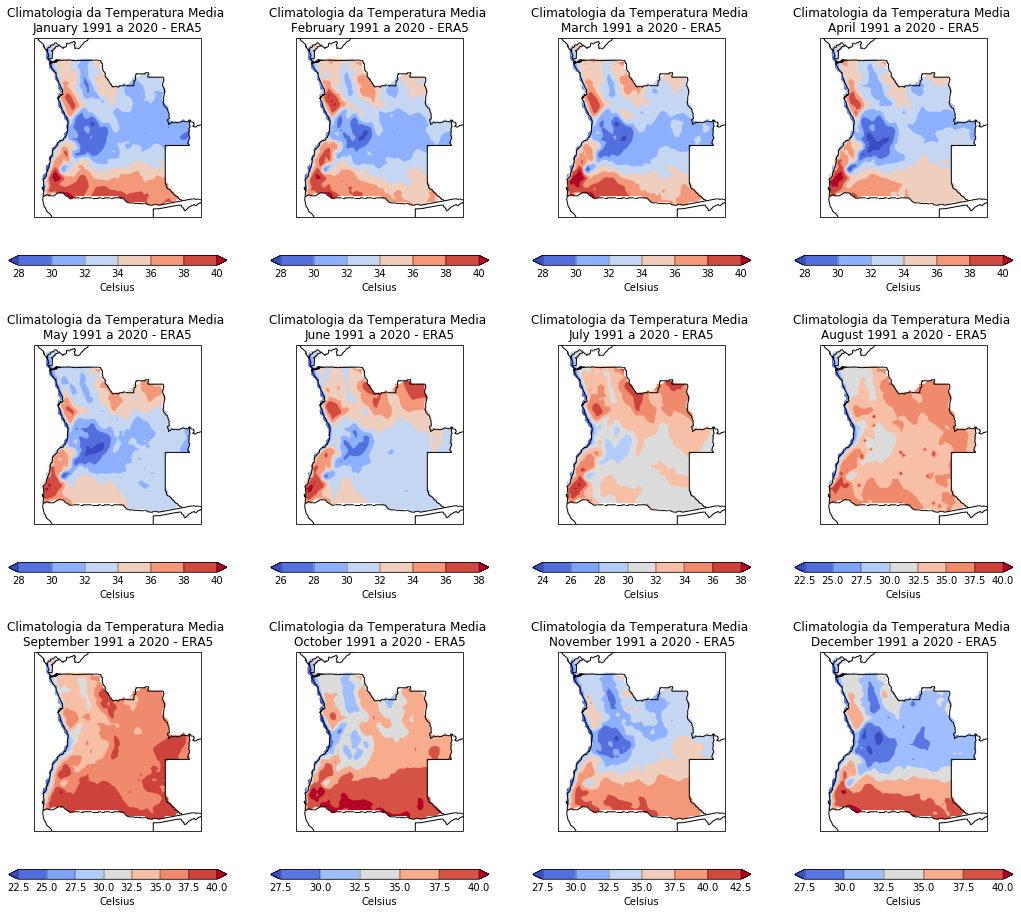

In [116]:
# tasmax
fig = plt.figure(figsize=(18,16))

nrows = 3
ncols = 4
for i in range(1,13):
    plt.subplot(nrows, ncols, i)
    maps = qplt.contourf(ago_max_temp[i-1],
                         cmap='coolwarm',
                         extend='both',
                        )
    plt.title('Climatologia da Temperatura Media \n'+calendar.month_name[i]+' 1991 a 2020 - ERA5')
    ax = plt.gca()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

# CLIMATOLOGIA SAZONAL

In [53]:
sazo = data

print(sazo)

Total precipitation / (m)           (time: 262992; latitude: 61; longitude: 61)
     Dimension coordinates:
          time                           x                 -              -
          latitude                       -                 x              -
          longitude                      -                 -              x
     Attributes:
          Conventions: CF-1.7


In [54]:
iris.coord_categorisation.add_season(sazo, 'time', name='seasons', 
                                     seasons=('jas','ond','jfm','amj'))

In [56]:
data_tot_seaso = sazo.aggregated_by(['seasons'], iris.analysis.SUM)/30.0
data_tot_seaso.convert_units('mm')
data_tot_seaso.units = 'mm/month'
data.rename('precipitation_flux')

for cube in [data_tot_seaso]:
    for coord in ['latitude', 'longitude']:
        cube.coord(coord).guess_bounds()

country = 'Angola'
geoms = get_geometries(country)
if len(geoms) != 1:
    raise ValueError('Only support one geometry')
    
ago_avg_seaso = mask_shape(data_tot_seaso, geoms[0])

print(ago_avg_seaso)

latitude longitude
unknown / (mm/month)                (time: 4; latitude: 61; longitude: 61)
     Dimension coordinates:
          time                           x            -              -
          latitude                       -            x              -
          longitude                      -            -              x
     Auxiliary coordinates:
          seasons                        x            -              -


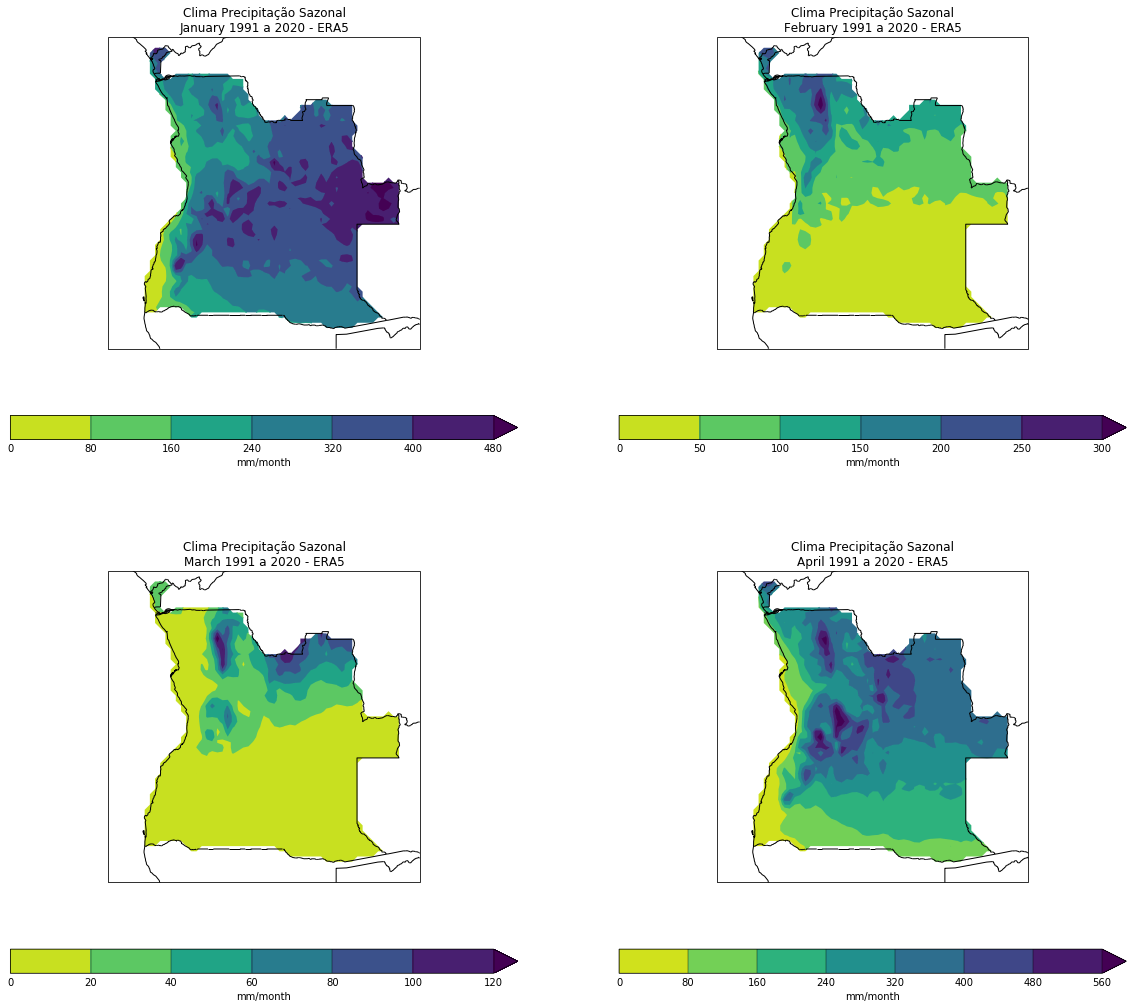

In [119]:
fig = plt.figure(figsize=(20,18))

name_list=['JAS','OND','JFM','AMJ']
nrows = 2
ncols = 2
for i in range(1,5):
    plt.subplot(nrows, ncols, i)
    maps = qplt.contourf(ago_avg_seaso[i-1],
                        extend='max',
                        cmap='viridis_r',
                        )
    
    #for names in name_list:
    plt.title('Clima Precipitação Sazonal\n'+calendar.month_name[i]+' 1991 a 2020 - ERA5')    #+names+' 
    
    ax = plt.gca()
    ax.coastlines()
    ax.add_feature(cf.BORDERS)

    

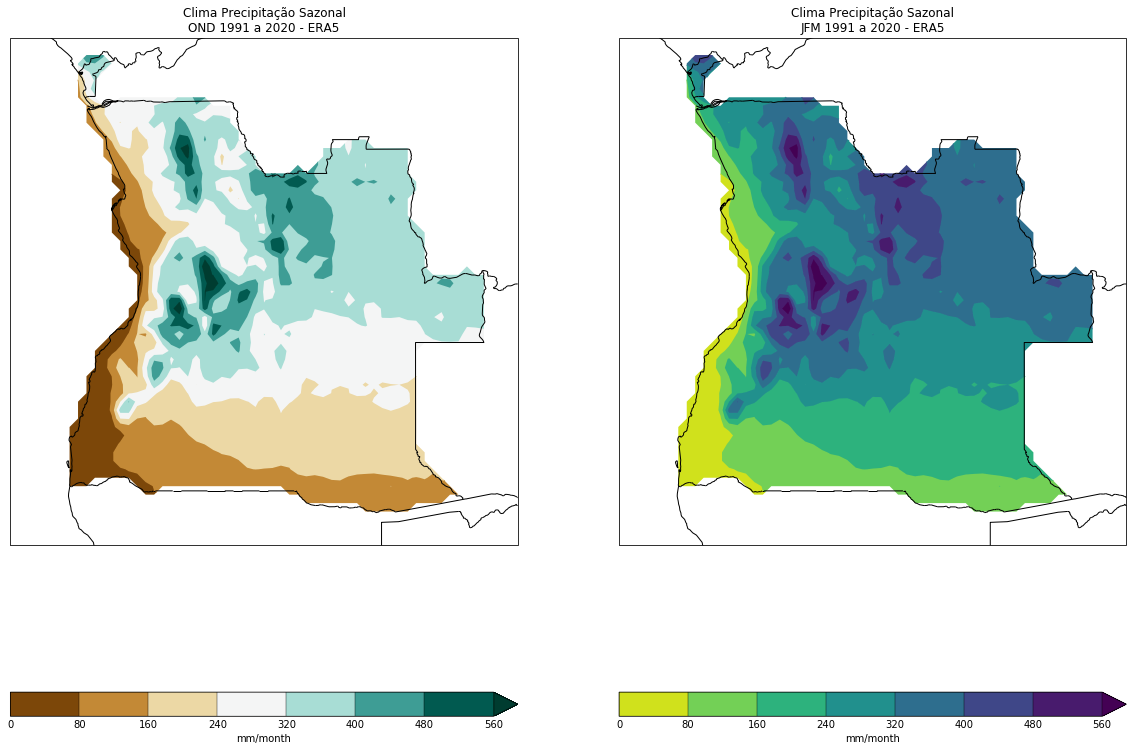

In [124]:
fig = plt.figure(figsize=(20,18))

plt.subplot(1, 2, 1)
maps = qplt.contourf(ago_avg_seaso[3],
                        extend='max',
                        cmap='BrBG',
                        )

plt.title('Clima Precipitação Sazonal\nOND 1991 a 2020 - ERA5')    #+names+' 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cf.BORDERS)

plt.subplot(1, 2, 2)
maps = qplt.contourf(ago_avg_seaso[3],
                        extend='max',
                        cmap='viridis_r',
                        )

plt.title('Clima Precipitação Sazonal\nJFM 1991 a 2020 - ERA5')    #+names+' 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cf.BORDERS)